# Задание
* Скачать все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, а также captcha подумайте как их можно обойти) +
* Извлеките все описания этих вакансий +
* Создайте аналогичный vacancy DataFrame только добавьте поле skills
* Переведите даты публикаций в datetime
* Постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите те вакансии с использованием python, которые вам интересны
* Определите по полю skills какие навыки больше всего востребованы для этих вакансий
* Постройте график наиболее востребованных навыков для аналитика данных

https://github.com/hhru/api

In [29]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [115]:
sber = 3529
num_per_page = 100
moscow = 1
page = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'

In [5]:
num_pages = requests.get(url).json().get('pages')
num_pages

13

In [116]:
all_vacancy_ids= []
for page in tqdm(range(num_pages)):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    all_vacancy_ids.extend(vacancy_ids)

  0%|          | 0/13 [00:00<?, ?it/s]

In [7]:
len(all_vacancy_ids)

1201

In [117]:
# Извлеките все описания этих вакансий
# Создайте аналогичный vacancy DataFrame только добавьте поле skills
df = pd.DataFrame()
columns = ['id', 'created_at', 'name', 'description', 'key_skills']
test_ids = list(pd.Series(all_vacancy_ids).sample(10)) #10 случайных id для тестов
for n in tqdm(all_vacancy_ids):
    url_id = f'https://api.hh.ru/vacancies/{n}'
    res = requests.get(url_id).json()
    df_ = pd.json_normalize(res)[columns]
    df = pd.concat([df, df_], axis=0)
    #dict_id_desc[n] = res_id.json().get('description')
df.reset_index(drop=True)

  0%|          | 0/1209 [00:00<?, ?it/s]

,id,created_at,name,description,key_skills
0,55415805,2022-07-06T13:45:50+0300,Менеджер по работе с клиентами,"<p>Сбер — лучший работодатель России. У нас более 60 компаний экосистемы и 14 тысяч подразделений по всей стране.</p> <p>Сбер ищет клиентского менеджера для работы в мобильных офисах. Это специалист, который консультирует клиентов по продуктам, услугам и сервисам Сбера в торговых центрах, аэропортах и гипермаркетах. Эта работа для активных и общительных людей, которые стремятся к карьере и финансовому достатку.</p> <p><strong>Ты подходишь нам, если ты готов:</strong></p> <ul> <li>продавать банковские продукты и сервисы в мобильных офисах Сбера: торговых центрах, магазинах, гипермаркетах, аэропортах</li> <li>рассказывать клиентам о преимуществах сервисов Сбера и экосистемы</li> <li>помогать клиентам оформлять продукты и услуги Сбера.</li> </ul> <p>Опыт работы консультантом или промоутером приветствуется.</p> <p><strong>Работа в Сбере – это:</strong></p> <ul> <li>стабильный оклад и социальная поддержка сотрудников</li> <li>официальное оформление с первого дня</li> <li>гибкий график работы, можно совмещать с учебой</li> <li>мобильная связь и корпоративный ipad</li> <li>оплата транспортных расходов</li> <li>корпоративная пенсионная программа</li> <li>расширенный ДМС с первого дня и льготное страхование для близких</li> <li>бесплатная подписка СберПрайм+, скидки на продукты компаний-партнеров</li> <li>корпоративное обучение в Виртуальной школе Сбера </li> <li>ипотека выгоднее на 4% для каждого сотрудника.</li> </ul> <p><strong>Присоединяйся к команде клиентских менеджеров Сбера!</strong></p>",[]
1,53361761,2022-06-27T12:47:08+0300,Клиентский менеджер малого и микробизнеса,"<p>Клиентский менеджер малого и микробизнеса – важная позиция в Сбербанке. Это эксперт, который помогает предпринимателю на старте и в развитии бизнеса. На этой позиции важно установить контакт с клиентом, с интересом и подробно расспросить о его бизнесе и предложить необходимые продукты. В этом тебе поможет планшет с программой индивидуального подбора продуктовых предложений.</p> <p> </p> <p>Позиция клиентского менеджера подойдет тем, кто хочет работать с корпоративными клиентами и профессионально развиваться. Она предполагает как вертикальную карьеру, так и возможность «горизонтального роста»: переход в смежные специальности или в другие отделения и города. Если ты стремишься к профессиональному росту, присоединяйся к команде малого и микробизнеса Сбербанка.</p> <p><strong>Задачи:</strong></p> <p>- консультировать корпоративных клиентов по продуктам банка и экосистемы</p> <p>- обслуживать юридические лица при открытии расчётного счета</p> <p>- формировать потребность клиента на комплексное обслуживание в банке</p> <p>- продавать банковские продукты и услуги</p> <p>- обучать клиентов функционалу и использованию продуктов и услуг банка</p> <p>- оформлять документацию по сделкам</p> <p>- помогать клиентам взаимодействовать с подразделениями банка.</p> <p><strong>Ждем от кандидата:</strong></p> <p>- высшее образование (финансы/банки, экономика/бухгалтерия)</p> <p>- опыт в сфере продаж или обслуживания клиентов от 1 года</p> <p>- грамотная и структурированная речь</p> <p>- умение находить общий язык и располагать к себе собеседника</p> <p>- многозадачность и организованность.</p> <p><strong>Работа в Сбере – это:</strong></p> <ul> <li>стабильный оклад и социальная поддержка сотрудников</li> <li>официальное оформление с первого дня</li> <li>мобильная связь и корпоративный ipad</li> <li>оплата транспортных расходов</li> <li>расширенный ДМС с первого дня и льготное страхование для близких</li> <li>бесплатная подписка СберПрайм+, скидки на продукты компаний-партнеров: Okko, Сбер Маркет, Delivery Club, Самокат, Сбер Еаптека и других</li> <li>ипотека выгоднее на 4% для каждого сотрудника.</li> </ul> <p> </p> <p><strong>Присоединяйся к команде Сбера!</strong></p>","[{'name': 'Активные продажи'}, {'name': 'Проведение презентаций'}, {'name': 'Привлечение клиентов'}, 

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 0 to 0
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1209 non-null   object        
 1   created_at   1209 non-null   datetime64[ns]
 2   name         1209 non-null   object        
 3   description  1209 non-null   object        
 4   key_skills   1209 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 56.7+ KB


In [119]:
# Переведите даты публикаций в datetime
# Постройте график опубликованных вакансий по датам
# Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
# Найдите те вакансии с использованием python, которые вам интересны
df['created_at'] = df['created_at'].astype('datetime64[ns]')

In [121]:
df['created_date'] = df['created_at'].dt.strftime('%Y-%m-%d')

In [122]:
for_gr = df.groupby('created_date').count()['id']

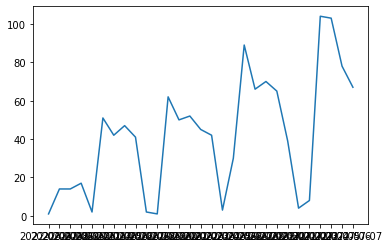

In [123]:
plt.plot(for_gr)

In [124]:
df.created_at.dt.dayofweek.value_counts(sort='desc')

1    271
2    256
0    255
3    238
4    139
6     39
5     11
Name: created_at, dtype: int64

In [195]:
cond1 = df.description.str.match('.*python.*', case=False)
cond2 = df.name.str.match('.*data.*', case=False)
cond3 = df.name.str.match('.*analyst.*', case=False)
cond4 = df.name.str.match('.*аналитик.*', case=False)
df_like = df[cond1 | cond3]
df_anlst = df[cond2 | cond3 | cond4]
df_anlst.name

0                                          Стажер Data Scientist
0                                      Стажер Data scientist NLP
0                                                       Аналитик
0                                            Junior data analyst
0                      Старший кредитный аналитик (малый бизнес)
                                ...                             
0    Senior DevOps (SberData, Управление распространения данных)
0                                   Senior/Middle Data Scientist
0                                      Lead Data Scientist ML/CV
0             Разработчик ETL-процессов / Data Engineer (Hadoop)
0                             Data инженер (Рекламная платформа)
Name: name, Length: 264, dtype: object

In [103]:
# Определите по полю skills какие навыки больше всего востребованы для этих вакансий
# Постройте график наиболее востребованных навыков для аналитика данных

In [186]:
def skills(obj):
    l = []
    for skills in obj.key_skills:
        for skill in skills:
            l.append(skill.get('name'))
    return pd.Series(l).value_counts()
skills(df_like)

Python                     138
SQL                         87
Linux                       67
Git                         52
Docker                      38
                          ... 
Организация мероприятий      1
QA Engineer                  1
CSS3                         1
Team Lead                    1
SQLAlchemy                   1
Length: 251, dtype: int64

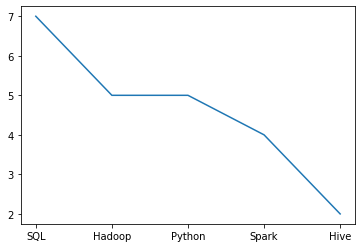

In [192]:
sk = skills(df_anlst)
plt.plot(sk[sk>1])